# Assessment 2

This assignment consists of three parts (A,B,C), which cover latent variables models and neural networks (Modules 4 and 5). The total marks of this assessment is 100.

## Part B. Neural Network vs. Perceptron [Neural Network’s Decision Boundary, 30 Marks]


In this part, you apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results.
### Question 2.1

Load <font color='blue'>Task3B_train.csv</font> and <font color='blue'>Task3B_test.csv</font> sets, plot the training data with classes are marked with different colors, and attach the plot to your report.

In [23]:
library(ggplot2)
library(repr)

In [24]:
options(repr.plot.width=8, repr.plot.height=8)

In [25]:
train <- read.csv('./datasets/Task2B_train.csv')
test <- read.csv('./datasets/Task2B_test.csv')
train <- train[complete.cases(train), ]                  # remove NAs
test <- test[complete.cases(test), ]                     # remove NAs

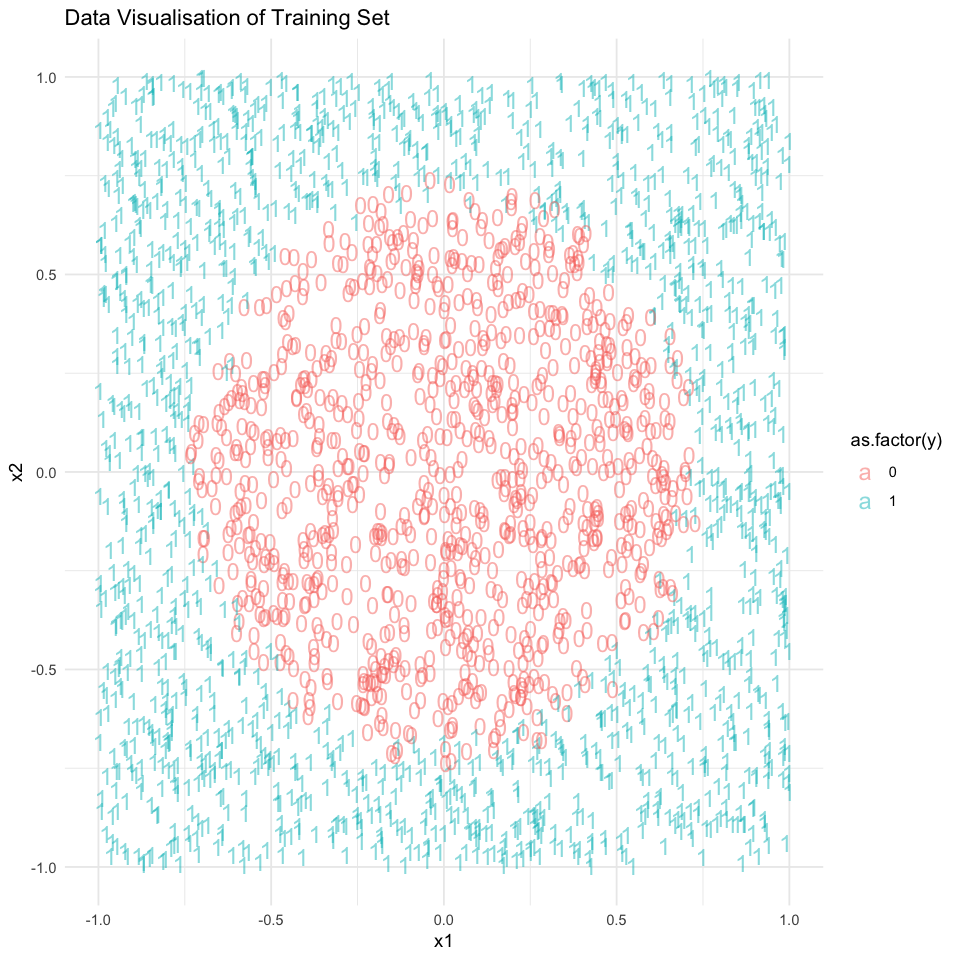

In [26]:
c0 <- '0'; c1 <- '1'
ggplot(data=train, aes(x=x1, y=x2, color=as.factor(y), label=ifelse(y==c0, '0', '1'))) +
    geom_text(size = 5, alpha=0.5) + ggtitle ('Data Visualisation of Training Set') + theme_minimal()

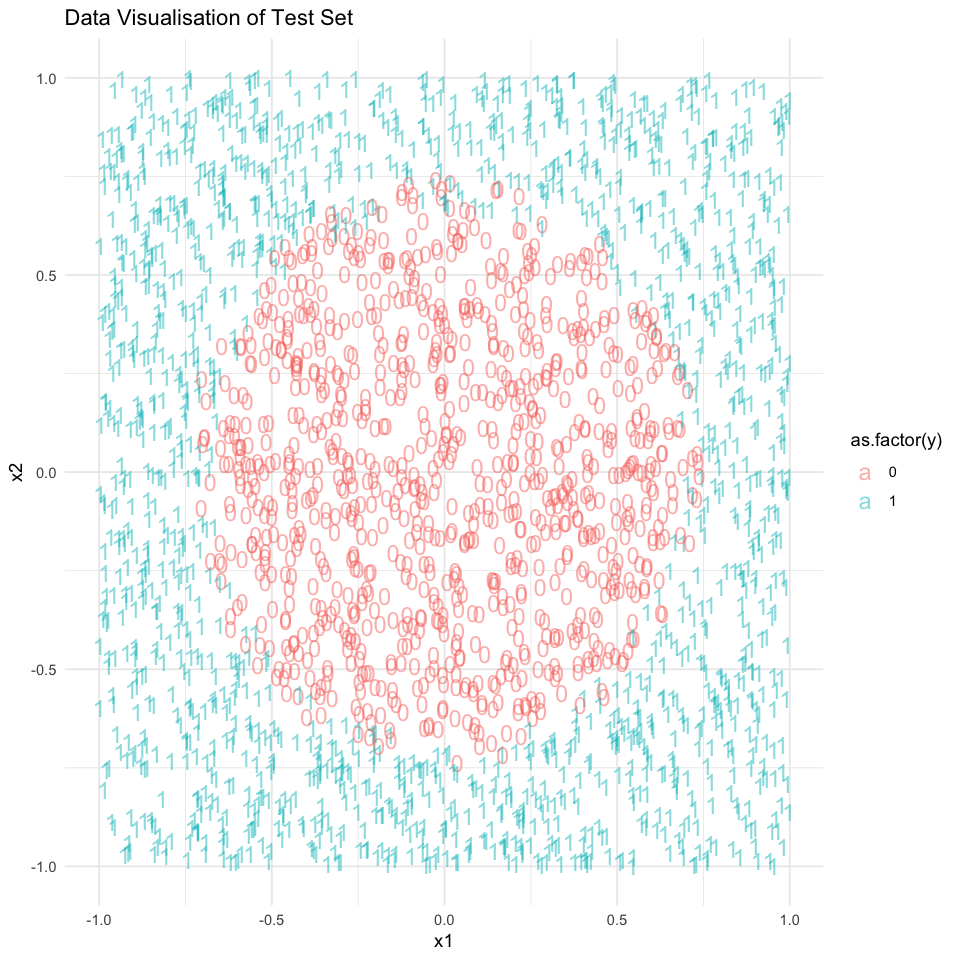

In [27]:
c0 <- '0'; c1 <- '1'
ggplot(data=test, aes(x=x1, y=x2, color=as.factor(y), label=ifelse(y==c0, '0', '1'))) +
    geom_text(size = 5, alpha=0.5) + ggtitle ('Data Visualisation of Test Set') + theme_minimal()

### Question 2.2

Run the implementations of Perceptron given to you in Activity 3.1, calculate the test error, and plot the test data while the points are colored with their estimated class labels; attach the pdf to your report.

<font color='orange'>Hint:</font>  Note that you must remove NA records from the datasets (using “complete.cases()’ function). You may also choose to change the labels from [0, 1] to [-1, +1] for your convenience. If you decided to use the code from Activity 3.1, you may need to change some initial settings (e.g., epsilon and tau.max). Finally, remember that perceptron is sensitive to initial weights. Therefore, we recommend to run your code a few times with different initial weights.

In [28]:
# pre-processing
train.len <- nrow(train)

train.data <- train[,c('x1', 'x2')]                         # extract the training data
train.label <- train[, 'y']                                 # extract the training label
train.label <- replace(train.label, train.label==0, -1)     # replace 0 with -1

test.data <- test[, c('x1', 'x2')]                          # extract the test data
test.label <- test[, 'y']                                   # extract the test label
test.data <- as.matrix(cbind(1, test.data))                 # add the bias feature for prediction
test.label <- replace(test.label, test.label==0, -1)        # replace 0 with -1    

In [29]:
head(train.label)
head(train.data)

[1] -1  1  1  1  1  1

x1,x2
-0.4365731,0.31994476
-0.3351625,-0.60774359
0.8914051,-0.11175734
-0.1892440,0.83644710
0.9231484,0.60879178
-0.8316286,-0.09605136


In [30]:
head(test.label)
head(test.data)

[1]  1 -1  1  1  1  1

,1,x1,x2
1,1,0.4973951,-0.5492695
2,1,0.2139925,0.6141635
3,1,-0.4656182,0.5093878
4,1,-0.1380630,0.8841224
5,1,0.6593270,0.3378901
6,1,0.6670054,0.6012369


First, let's define some auxilary functions.

In [31]:
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}

is.a.miss <- function(Phi, W, T1){
  return((W %*% Phi) * T1 < 0)
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

Then we define a perceptron function.

In [32]:
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA, nrow=tau.max, ncol=ncol(Phi))                              # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1                                              # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1)                               # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1)             # Record error for initial weights
  tau <- 1                                                                   # Iteration counter 
  terminate <- FALSE                                                         # Termination status
  
  while(!terminate){
    indx <- sample(1:N1, replace = FALSE)                                    # Resuffling train data and associated labels
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){                                # Look for missclassified samples
        tau <- tau +1                                                         # Update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]                          # Update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)    # Update the records
        eta = eta * 0.99                                                      # Decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
     plot(error.rec[complete.cases(error.rec),], type="l", xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix when the loop stops before tau == tau.max
  return(W[nrow(W),])         # return the last wight vector
}

Run the perceptron model.

The weights are:  -0.04092401 0.1507682 -0.2707561

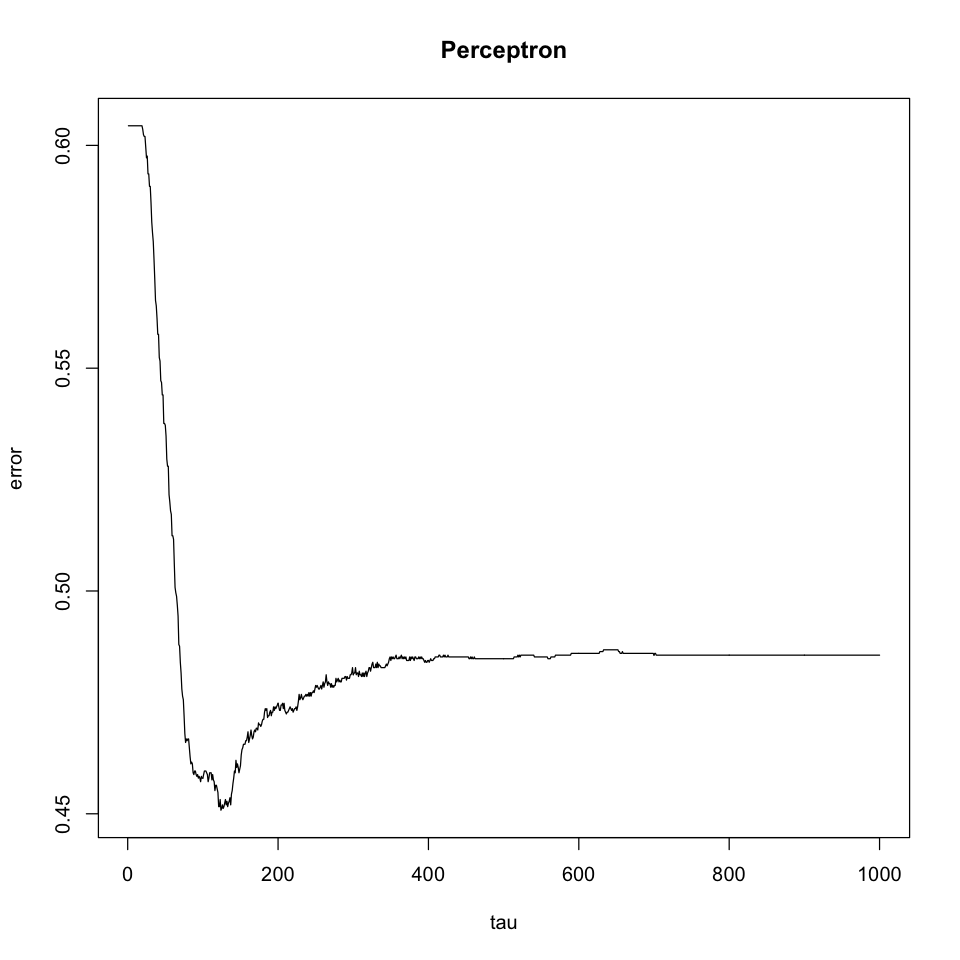

In [33]:
W <- perceptron.build(train.data, train.label, tau.max = 1000, plotting = TRUE) 
cat('The weights are: ', W)

In [34]:
# let's have a look the prediction label
pred = ifelse(test.data %*% W >0, '1', '0')
head(pred)

1,1
2,0
3,0
4,0
5,0
6,0


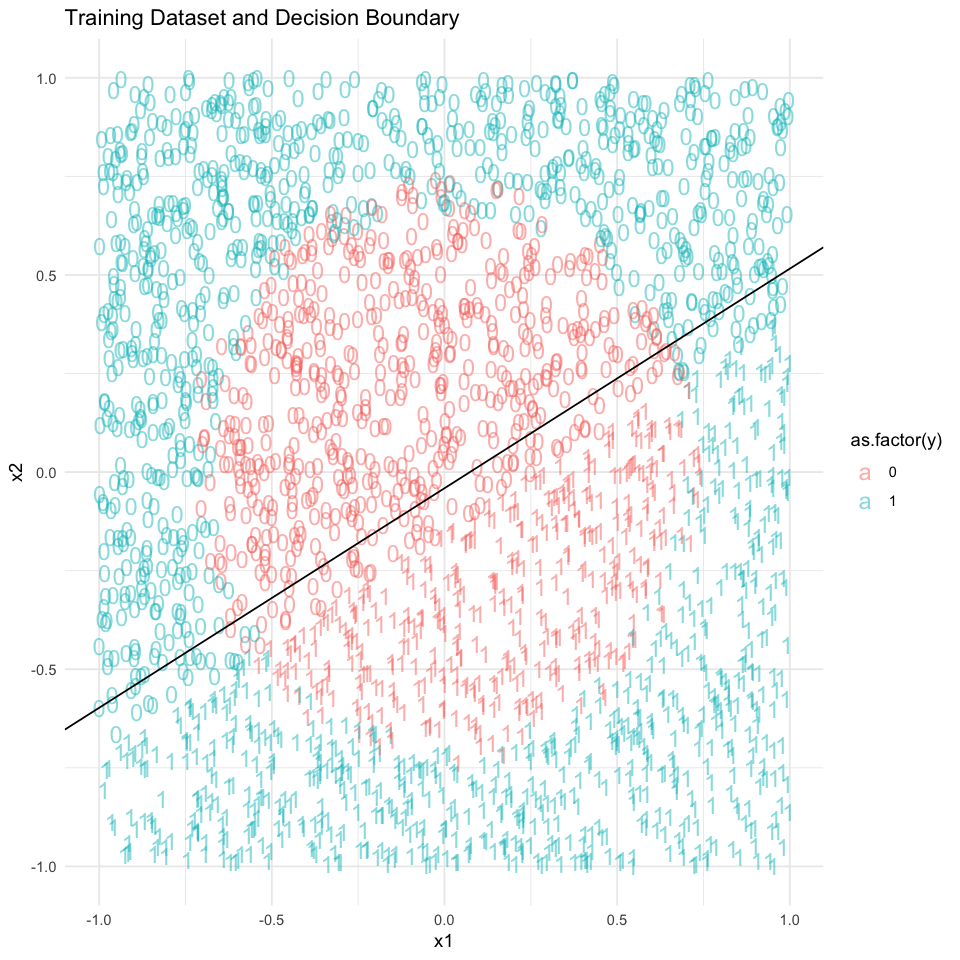

In [35]:
# Visualisation
ggplot(data=test, aes(x=x1, y=x2, color=as.factor(y), label=as.factor(pred))) +
    geom_text(size = 5, alpha=0.5) +
    geom_abline(intercept=W[1], slope=-W[2]/W[3]) +
    ggtitle('Training Dataset and Decision Boundary') +
    theme_minimal()

The blue colour indicates the class 1 points whereas the red colour is for class 0. The actual labels are the predictions for the test set. The error is around 0.5. This is because the dataset was non-linearly separable and hence we can only achieve around 50% accuracy using the perceptron technique. 

### Question 2.3 

Run the 3-layer Neural Network given to you in Activity 5.1 with different values of K (i.e, number of units in the hidden layer) and record testing error for each of them; plot the error vs K and attach it to your report. Based on this plot, find the best K and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the
plot to your report. 

<font color='orange'>Hint:</font>  In case you choose to use the provided examples in Activity 5.1, you may need to transpose the dataset () using “t()” function and use different values for parameter settings (e.g., lambda). We also recommend to change K to 2, 4, 6, .., 100 (i.e. from 2 to 100 with the step size of 2).

First, let's define some auxilary functions.

In [36]:
# this function allows us to have functions with multiple outputs
# credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

In [37]:
# the activation function 
h <- function(z, a=1) { #activation function (sigmoid here)
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}

# the derivitive of the activation function (tanh here)
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}

# class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}

In [40]:
# prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}

# feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}

# backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}

NN build function

In [43]:
nn.build <- function(K, X1, T1, epoch.max=50, eta = 0.1, lambda = 0.01){
   # initialization
   D <- nrow(X1)
   if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
   N <- ncol(X1)
 
   W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
   b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
   W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
   b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

   for (epoch in 1:epoch.max){   
        ## delta vectors/matrices initialization
        W1.d <- W1 *0
        b1.d <- b1 *0
        W2.d <- W2 *0
        b2.d <- b2 *0

        for (i in 1:N){
              ## Feedforward:
              list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
              ## Backpropagation:
              list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
              ## calculate the delta values
              ### 1st layer
              W1.d <- W1.d + d2 %*% t(a1)
              b1.d <- b1.d + d2
              ### 2nd layer
              W2.d <- W2.d + d3 %*% t(a2)
              b2.d <- b2.d + d3
        }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
   }
  return(list('w1'=W1, 'w2'=W2, 'b1'=b1, 'b2'=b2))
}

Now, let's write a for loop to test different values of k.

In [44]:
errors <- matrix(NA, nrow=length(seq(2,100,2)), ncol=1)    # initialise an empty matrix to record the test error for each k value

for (k in seq(2,100,2)){                                   # this code is very time consuming, could be running for several hours 
    list[W1, W2, b1, b2] <- nn.build(K=k, X1 = t(train.data), T1 = train.label, epoch.max=300)
    errors[k/2]<- error.rate(nn.predict(t(test.data[,2:ncol(test.data)]), W1, W2, b1, b2), test.label)
    cat('Loop', k/2, 'has finished')
}

In [49]:
# check the error rate
dim(errors)

[1] 50  1

Visualise the test error

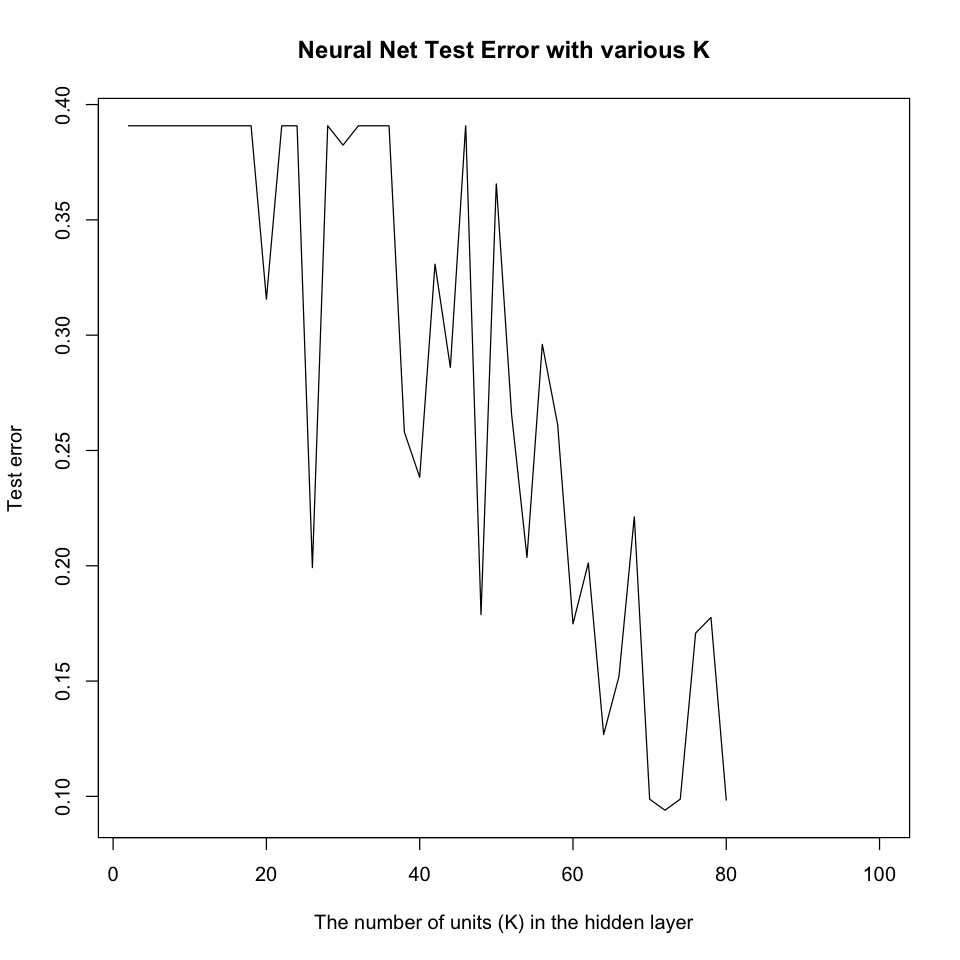

In [46]:
plot(x=seq(2,100,2), y=errors, xlab = 'The number of units (K) in the hidden layer', 
     ylab = 'Test error', main = 'Neural Net Test Error with various K', type = 'l')

As can be seen, the error is the lowerest when K equals 98. Let's visualisa the classification on the test set using the best K. 

In [47]:
list[W1, W2, b1, b2] <- nn.build(K=98, X1 = t(train.data), T1 = train.label, epoch.max=300)  # build model using the best k value
pred <- as.numeric(nn.predict(t(test.data[,2:ncol(test.data)]), W1, W2, b1, b2))             # make predictions
pred <- as.factor(ifelse(pred == 1, '+', '-'))                                               # change the prediction label
#head(pred)

Finally let's visualise the prediction and the decision boundary of the NN model.

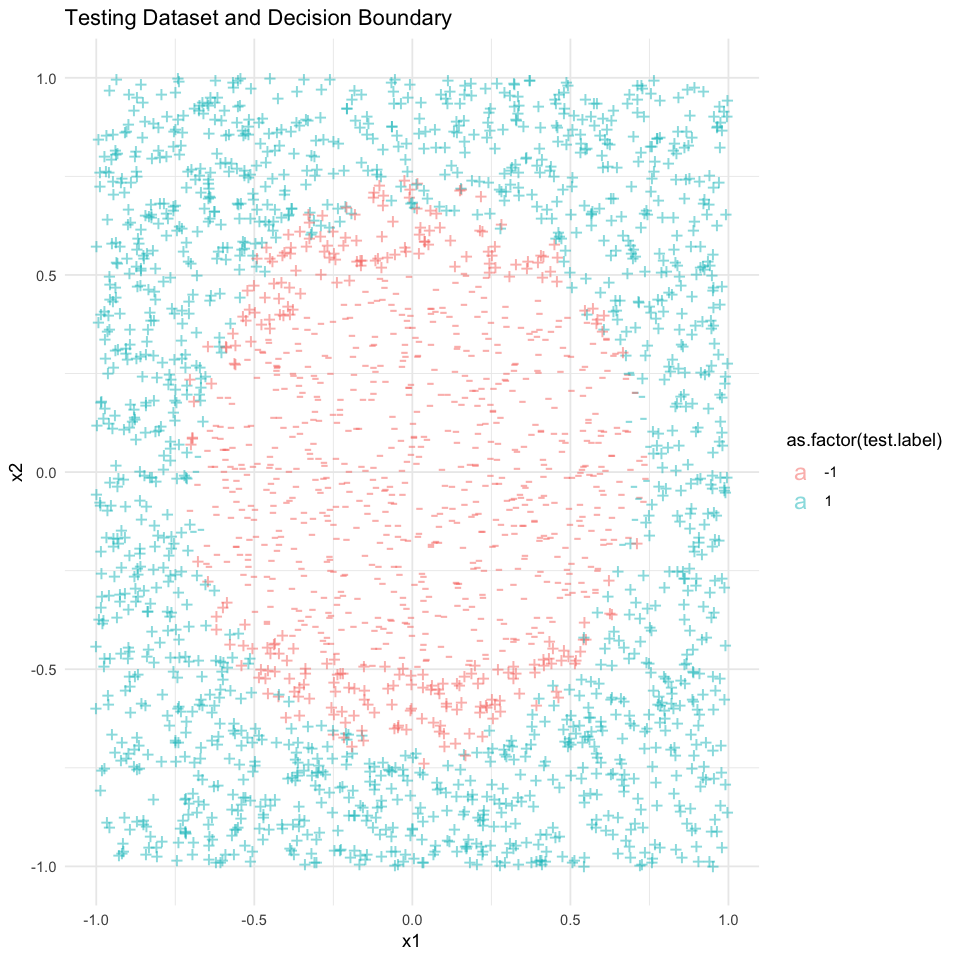

In [48]:
ggplot(data=as.data.frame(test.data), aes(x=x1, y=x2, label=as.factor(pred), color=as.factor(test.label))) +
    geom_text(size=5, alpha=0.5) +
    ggtitle('Testing Dataset and Decision Boundary') +
    theme_minimal()

### Question 2.4

In your Notebook file, explain the reason(s) responsible for such difference between perceptron and a 3-layer NN.

<font color='orange'>Hint:</font>  Look at the plots and think about the model assumptions.

<font color='blue'>Answer: </font> In this part we explored two different methods of classification namely perceptron and neural networks. We see two completely different outcomes for the two algorithms. In perceptron model, it's a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. This can be seen as a linear black line in the graph. Due to its nature, the expected accuracy of perceptron models should be around 50% due to the nature of our data (i.e. linearly non-separable). On the other hand, neural networks are non-linear classifier. As can be seen in the later plot, the red cross indicates misclassified data. The misclassification rate is low and the majority of misclassified points are located at the top-left and bottom-right corners. This is much better comparing to perceptron. Hence, given a linearly non-separable dataset, the neural network model performs much better just as expected. 